In [1]:
import os, sys
import numpy as np
import pandas as pd
import itertools
from collections import defaultdict

import seaborn as sns
# Matplotlib for additional customization
from matplotlib import pyplot as plt
%matplotlib inline

# Inits

In [48]:
# get currently working directory
base_dir = os.getcwd()
plots_folder = 'plots'

# load functions from other notebooks
helpers_file = os.path.join(base_dir, 'helpers.ipynb')
%run $helpers_file

current_module = sys.modules[__name__]

class Strategies:
    stypes = [
        'random',
        'brute_force',
        'bfs_yloss',
        'bidirectional',
        'combo',
    ]

# Movielens 10M

## Load data

In [47]:
## uncomment the following lines if you want to run the various strategies in budget_strategies
# implemented_strategies = os.path.join(base_dir, 'budget_strategies.ipynb')
# %run $implemented_strategies

%store -r random_cfs
%store -r brute_force_cfs

%store -r bfs_yloss_cfs
# %store -r dfs_yloss_cfs
# %store -r bestfs_yloss_cfs

%store -r bidirectional_cfs
%store -r combo_cfs

## Prepare data

In [67]:
from collections import Counter


# cnt = dict.fromkeys(most_sim_cfs.keys())
# no_target_achieved_cases = dict.fromkeys(most_sim_cfs.keys())
cnt = defaultdict(dict)
no_target_achieved_cases = defaultdict(list)
strs_prefix = ''

for i in range(1):
    cnt, no_target_achieved_cases = convert_res_to_lists(
        getattr(current_module, f'{strs_prefix}{Strategies.stypes[0]}_cfs')[i],
        cnt, no_target_achieved_cases, f'random_{i}')
    cnt, no_target_achieved_cases = convert_res_to_lists(
        getattr(current_module, f'{strs_prefix}{Strategies.stypes[1]}_cfs')[i],
        cnt, no_target_achieved_cases, f'brute_force_{i}')

    cnt, no_target_achieved_cases = convert_res_to_lists(
        getattr(current_module, f'{strs_prefix}{Strategies.stypes[2]}_cfs')[i + 1],
        cnt, no_target_achieved_cases, f'bfs_{i}')

    cnt, no_target_achieved_cases = convert_res_to_lists(
        getattr(current_module, f'{strs_prefix}{Strategies.stypes[3]}_cfs')[i],
        cnt, no_target_achieved_cases, f'bidirectional_001_{i}')
    cnt, no_target_achieved_cases = convert_res_to_lists(
        getattr(current_module, f'{strs_prefix}{Strategies.stypes[3]}_cfs')[i + 1],
        cnt, no_target_achieved_cases, f'bidirectional_5_{i}')
    cnt, no_target_achieved_cases = convert_res_to_lists(
        getattr(current_module, f'{strs_prefix}{Strategies.stypes[3]}_cfs')[i + 2],
        cnt, no_target_achieved_cases, f'bidirectional_999_{i}')

    cnt, no_target_achieved_cases = convert_res_to_lists(
        getattr(current_module, f'{strs_prefix}{Strategies.stypes[4]}_cfs')[i],
        cnt, no_target_achieved_cases, f'combo_001_{i}')
    cnt, no_target_achieved_cases = convert_res_to_lists(
        getattr(current_module, f'{strs_prefix}{Strategies.stypes[4]}_cfs')[i + 1],
        cnt, no_target_achieved_cases, f'combo_5_{i}')
    cnt, no_target_achieved_cases = convert_res_to_lists(
        getattr(current_module, f'{strs_prefix}{Strategies.stypes[4]}_cfs')[i + 2],
        cnt, no_target_achieved_cases, f'combo_999_{i}')

In [68]:
methods_supported = ['Brute_Force', 'Random', 'BFS'] + \
    [f'BiDirectional_{m}' for m in ['001', '5', '999']] + \
    [f'Combo_{m}' for m in ['001', '5', '999']]

strategies = [('init', 2), ('best', 3)]
custom_range = [9, 29]
target_pos = list(cnt.keys())
cnames = ['user_id', 'method', 'pos', 'budget', 'init_budget', 'best_budget', 'cardinality', 'cfs_orig', 'cfs']

rows, cols = 5, 1

tmp_dfs = []
for col in range(cols):
    for pos, row in zip(target_pos, range(rows)):

        tmp_dfs.append(pd.DataFrame.from_records(list(
            itertools.chain(*(
                zip(v[6], itertools.repeat(k), itertools.repeat(pos), v[i], v[2], v[3],
                    itertools.repeat(i - custom_range[0] + 1), v[7], v[8])
                for k, v in cnt[pos].items() if f'_{col}' in k and k.rsplit('_', 1)[0] in map(lambda x: x.lower(), methods_supported)
                for i in range(custom_range[0], custom_range[1])
            ))), columns=cnames
        ))

df = pd.concat(tmp_dfs, ignore_index=True)

In [69]:
idx = df.loc[(df['cfs_orig'] == df['cfs'])].duplicated(subset=['user_id', 'method', 'pos'], keep='last')
df.loc[(df['cfs_orig'] == df['cfs']) & ~idx, ['budget']] = df.loc[(df['cfs_orig'] == df['cfs']) & ~idx]['best_budget']

In [70]:
def grouping(x, i=1):
    users_uniq = x['user_id'].nunique()
    print(x.columns)
    mask = x.apply(lambda d : d['cardinality'] <= i)
    no_users = x.loc[mask].sum()
#     journal_author = x.groupby('Journal').apply(lambda d : ((((d['Subscription'] == 1) & (d['Known_author'] == 1)).sum()) > 0)).sum()
    return pd.Series([no_users])
# ddf = df.groupby(['method', 'pos']).apply(grouping)


# # 1st plot: %users per card
all_users = df['user_id'].nunique()

res = []
for i in range(1, 21):
    res.append(df[(df['budget'] > 0) & (df['cardinality'] <= i) & (df['best_budget'] <= 1000)]
               .groupby(['method', 'pos'], sort=False)[['user_id', 'cfs']]
               .nunique()
               .reset_index())

ddf = pd.concat(res, ignore_index=True)
ddf['%users'] = (ddf['user_id'] / all_users) * 100

# 2nd plot: average budget
max_card = 5
init = 100
end = 1001
step = 100


res = []
for b in range(init, end, step):
    aggregated = df[(df['budget'] > 0) & (df['best_budget'] <= b)]\
        .groupby(['method', 'pos'], sort=False)\
        .agg(card_mean=('cfs', 'mean'), no_users=('user_id', 'nunique'))\
        .reset_index()
    aggregated['budget_thres'] = b
    aggregated['max_users'] = aggregated.groupby(['pos'])['no_users'].transform(max)
    res.append(aggregated)

ddf2 = pd.concat(res, ignore_index=True)
ddf2['%users'] = (ddf2['no_users'] / all_users) * 100
# ddf2['combined_means'] = ((ddf2['card_mean'] * ddf2['no_users']) + (20 * (ddf2['max_users'] - ddf2['no_users']))) / (ddf2['max_users'])
ddf2['combined_means'] = ddf2['card_mean']


# 3rd plot:
def aggf(data):
    users_grouping = data.groupby(['user_id']).apply(
        lambda d: d.loc[d['budget'] == d['budget'].max()]
    )

    return pd.Series(
        [users_grouping['budget'].mean(),
         users_grouping['user_id'].count()],
        ['avg_budget', 'no_users']
    )

# .apply(lambda d: pd.Series(dict(
#             avg_budget=d.groupby(['user_id']).apply(
#                 lambda x: x.loc[(x['cardinality'] == x['cardinality'].min()), 'budget'].mean(),
#             ),
# #             no_users=d.loc[d['cardinality'],min(), 'user_id'].count(),
#             max_users=d['user_id'].nunique()
#         )))\


res = []
for i in range(5, 0, -1):
    aggregated = df[(df['budget'] > 0) & (df['cardinality'] <= i) & (df['best_budget'] <= 1000)]\
        .groupby(['method', 'pos'], sort=False)\
        .apply(aggf)\
        .reset_index()
    aggregated['cardinality'] = i
    res.append(aggregated)

ddf3 = pd.concat(res, ignore_index=True)
ddf3['%users'] = (ddf3['no_users'] / all_users) * 100

## Plots

In [72]:
import matplotlib.ticker as mticker


sns.set_theme(style="ticks", font_scale=1.5, )

# Create an array with the colors you want to use
# colors = ["#FF0B04", "#4374B3", "#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
colors = ['black', 'darkred', 'green', 'darkblue', 'dodgerblue', 'darkturquoise', 'darkgoldenrod', 'orange', 'chocolate']

# Set your custom color palette
custom_palette = sns.set_palette(sns.color_palette(colors))

# custom_markers = ['o', 'v', '^', 's', 'P', 'X', '<', '>', 'D', ]
custom_markers = ['o', 'v', '^', 'P', 'P', 'P', 'X', 'X', 'X']
custom_dashes = [(1, 0), (4, 0), (4, 0), (4, 0), (6, 2), (1, 2), (1, 0), (6, 2), (1, 2)]

In [ ]:
a4_dims = (11.7, 8.27)
# fig, ax = plt.subplots(figsize=a4_dims)
# penguins = sns.load_dataset("penguins")

g = sns.catplot(
    data=ddf[(ddf['pos']==3) ], kind="bar",
    x="cfs", y="%users", hue="method",
    ci="sd", capsize=0.1, palette="dark", alpha=.8, height=6, aspect=4,
)
# g = sns.lineplot(ax=ax,
#     data=ddf[(ddf['pos']==3) ],
#     x="cfs", y="%users", hue="method", style='method',
#     palette="dark", markers=True, markersize=9, dashes=False,
# )

# num_locations = len(ddf[ddf['pos'] == 3].groupby('cfs').groups.keys())
# hatches = itertools.cycle(['//', '+', '-', 'x', '\\', '*', 'o', '.'])
# for i, bar in enumerate(g.ax.patches):
#     if i % num_locations == 0:
#         hatch = next(hatches)
#     bar.set_hatch(hatch)

# g.ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=3, fancybox=True, shadow=False)

# sns.despine(left=True)
# ax.set(xlabel="cardinality", ylabel="% users")
# g.get_legend().set_title("")
# lgnd = plt.legend(fancybox=True, frameon=True, labelspacing=1, borderpad=1)

# for lh in lgnd.legendHandles:
#     lh.set_markersize(80)
#     lh.set_sizes = [50]

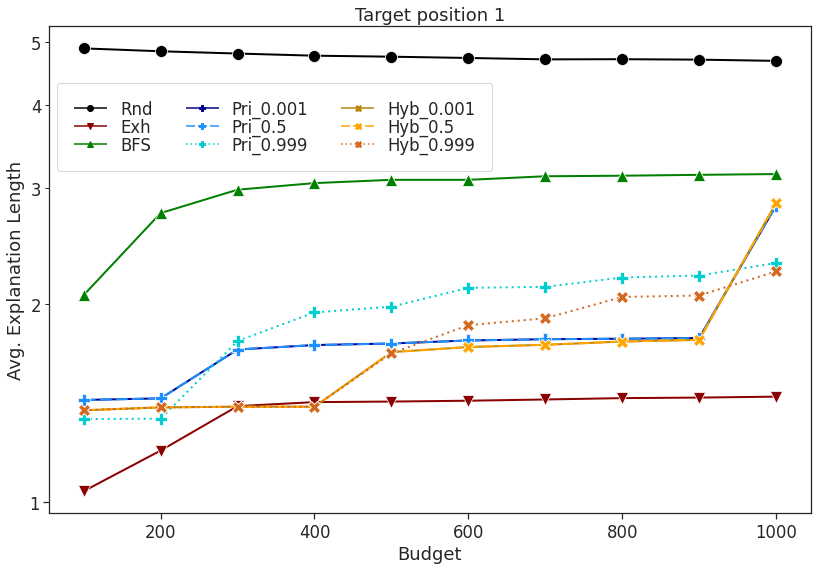

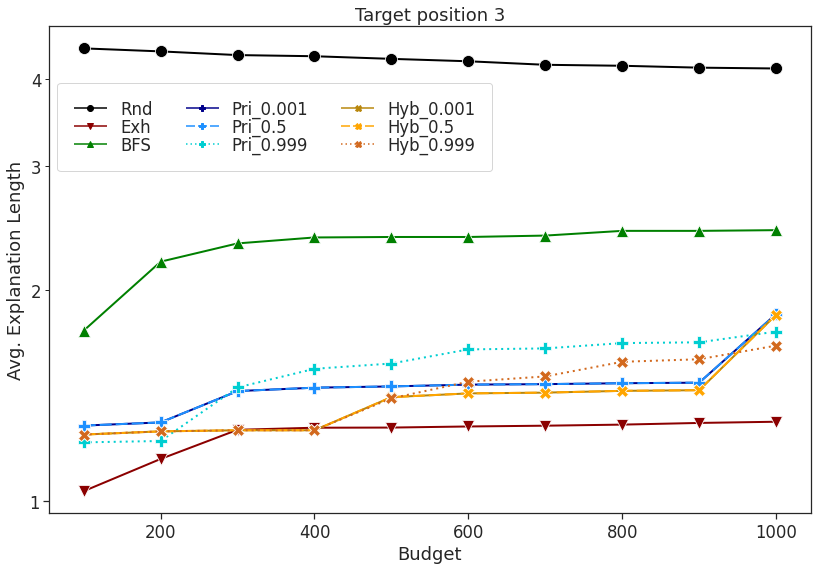

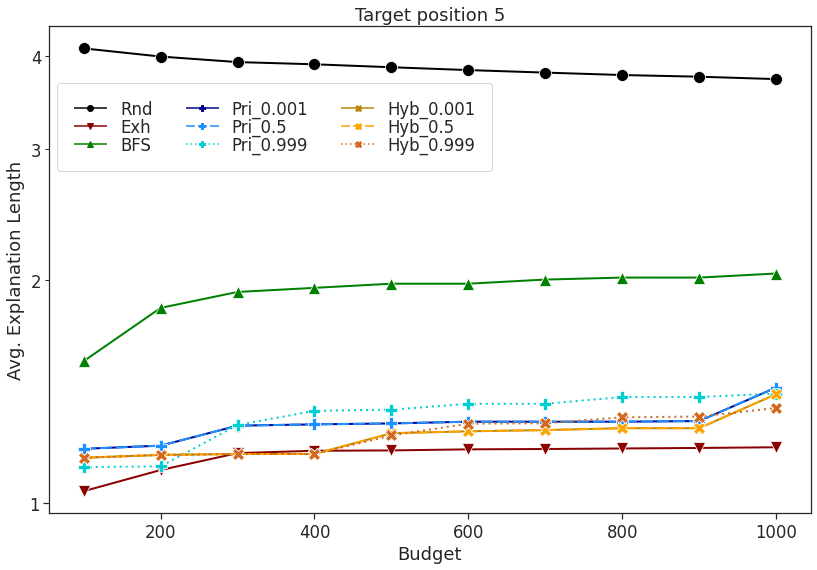

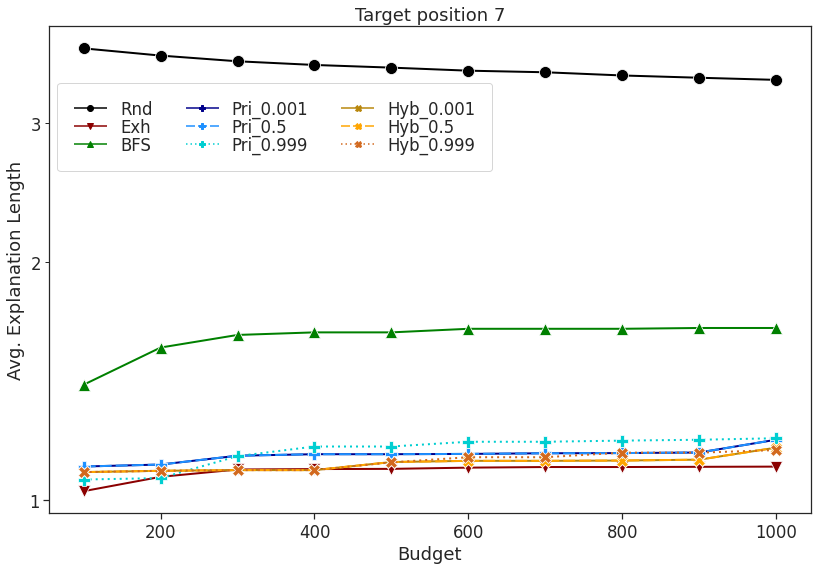

In [73]:
# Draw a nested barplot by species and sex
# g = sns.catplot(
#     data=ddf2[ddf2['pos']==3], kind="bar",
#     x="budget_thres", y='combined_means', hue="method",
#     ci=None, palette="dark", alpha=.8, height=6, aspect=4,
# )

# num_locations = len(ddf2.groupby('budget_thres').groups.keys())
# hatches = itertools.cycle(['//', '+', '-', 'x', '\\', '*', 'o', '.'])
# for i, bar in enumerate(g.ax.patches):
#     if i % num_locations == 0:
#         hatch = next(hatches)
#     bar.set_hatch(hatch)

# g.ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=3, fancybox=True, shadow=False)

# g.despine(left=True)
# g.set_axis_labels("threshold", "cardinality average")
# g.legend.set_title("")

rows, cols = len(df.groupby('pos').groups.keys()), 1

for i, p in enumerate(df.groupby('pos').groups.keys()):
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize=a4_dims)

    g = sns.lineplot(
        ax=ax, data=ddf2[(ddf2['pos'] == p)],
        x="budget_thres", y="card_mean", hue="method", style='method',
        palette=custom_palette,
        markers=custom_markers, markersize=12, lw=2, ls='solid', dashes=custom_dashes
    )

    g.set(yscale='log')
#     locmin = mticker.LogLocator(base=10, subs=np.arange(0, 1, 0.1), numticks=12)
#     ax.yaxis.set_minor_locator(locmin)
#     ax.yaxis.set_minor_formatter(mticker.NullFormatter())
#     ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
#     ax.yaxis.get_major_formatter().set_scientific(False)
#     ax.yaxis.get_major_formatter().set_useOffset(False)

    # Turns on grid on the Axis.
#     plt.grid(True, which="both", ls="--", c='gray')
#     scientific_formatter = mticker.FuncFormatter()
#     ax.yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))
    ax.yaxis.set_minor_formatter(mticker.FormatStrFormatter('%.0f'))

    lgnd = ax.legend(fancybox=True, frameon=True, labelspacing=0, borderpad=1, loc='upper left', bbox_to_anchor=(0, 0.9), ncol=3,)

    # replace labels
    new_labels = ['Rnd', 'Exh', 'BFS', 'Pri_0.001', 'Pri_0.5', 'Pri_0.999', 'Hyb_0.001', 'Hyb_0.5', 'Hyb_0.999']
    for t, l in zip(lgnd.texts, new_labels): t.set_text(l)

    ax.set(xlabel="Budget", ylabel="Avg. Explanation Length")
    ax.set_title(f'Target position {p}')

    fig.tight_layout()
    plt.savefig(os.path.join(plots_folder, f"avg_card_to_thres_pos_{p}.pdf"), dpi=300)

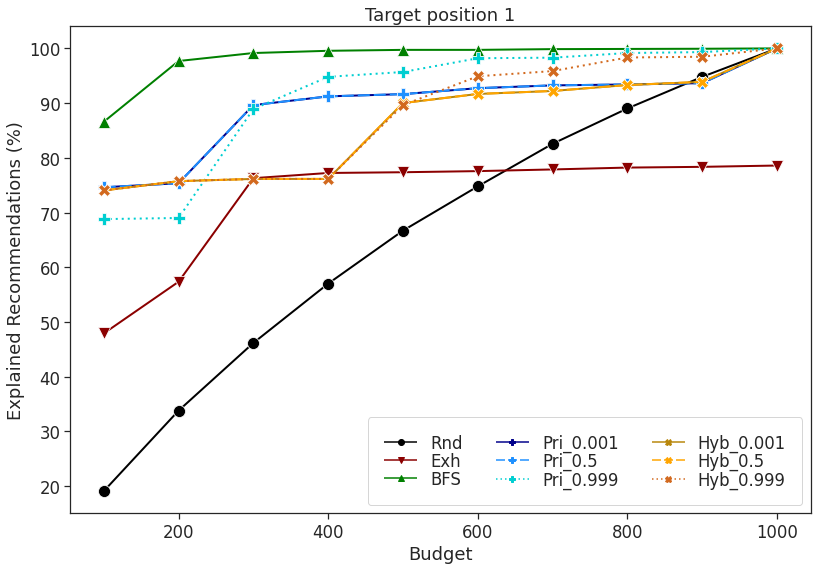

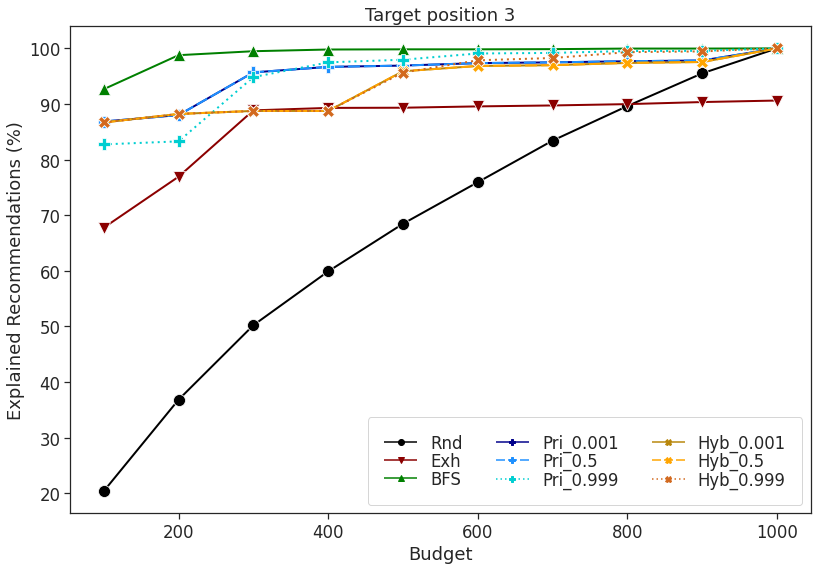

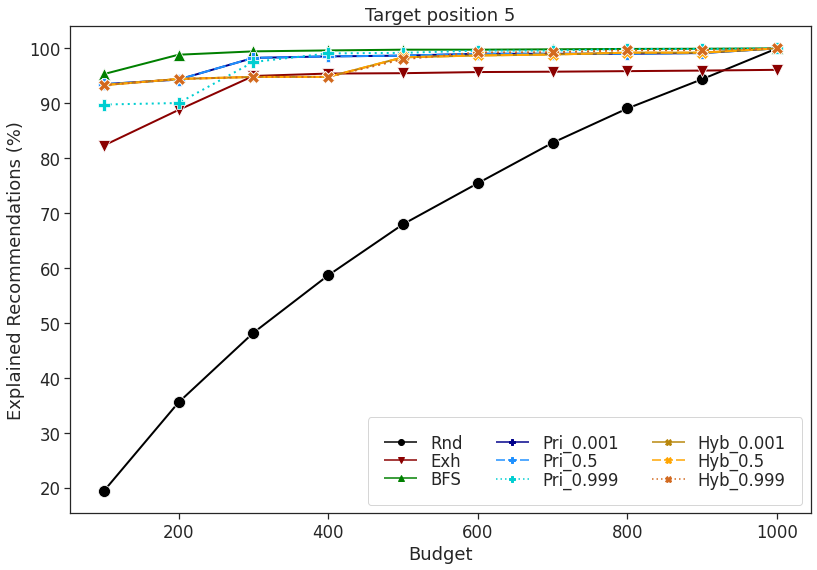

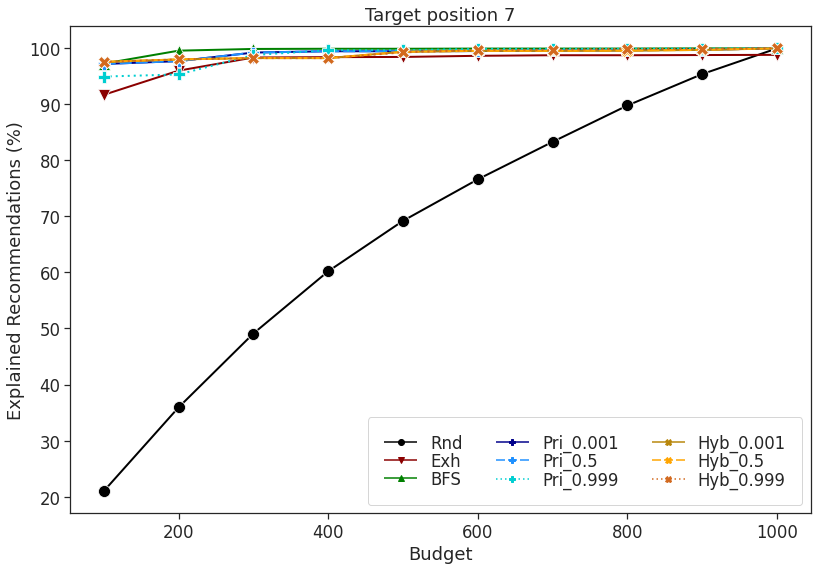

In [74]:
rows, cols = len(df.groupby('pos').groups.keys()), 1

for i, p in enumerate(df.groupby('pos').groups.keys()):
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize=a4_dims)

    g = sns.lineplot(
        ax=ax, data=ddf2[(ddf2['pos'] == p)],
        x="budget_thres", y="%users", hue="method", style='method',
        palette=custom_palette, markers=custom_markers, markersize=12, dashes=custom_dashes, lw=2,
    )

#     g.set(yscale='log')
#     locmin = mticker.LogLocator(base=10, subs=np.arange(0, 1, 0.1), numticks=12)
#     ax.yaxis.set_minor_locator(locmin)
#     ax.yaxis.set_minor_formatter(mticker.NullFormatter())

#     plt.grid(True, which="both", ls="--", c='gray')

    lgnd = ax.legend(fancybox=True, frameon=True, labelspacing=0, borderpad=1, loc='lower right', ncol=3,)

    # replace labels
    new_labels = ['Rnd', 'Exh', 'BFS', 'Pri_0.001', 'Pri_0.5', 'Pri_0.999', 'Hyb_0.001', 'Hyb_0.5', 'Hyb_0.999']
    for t, l in zip(lgnd.texts, new_labels): t.set_text(l)

    ax.set(xlabel="Budget", ylabel="Explained Recommendations (%)")
    ax.set_title(f'Target position {p}')

    fig.tight_layout()
    plt.savefig(os.path.join(plots_folder, f"users_percent_to_thres_pos_{p}.pdf"), dpi=300)

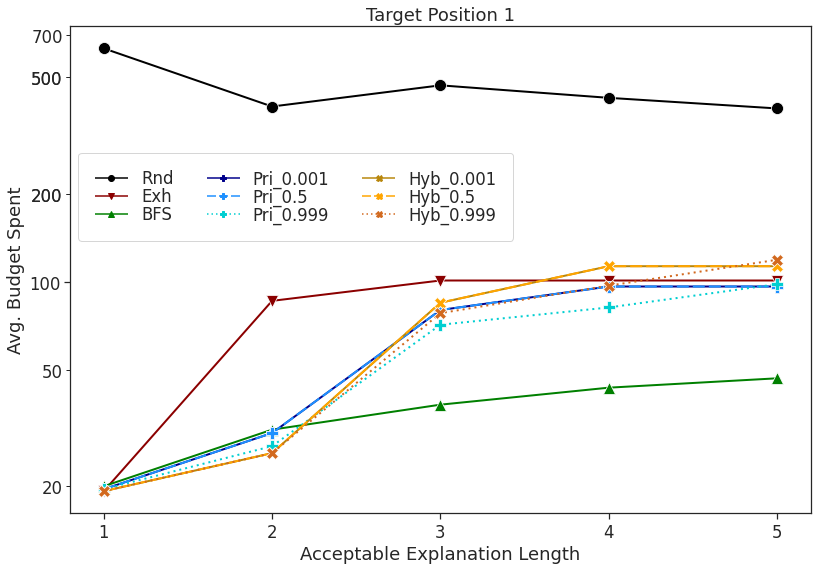

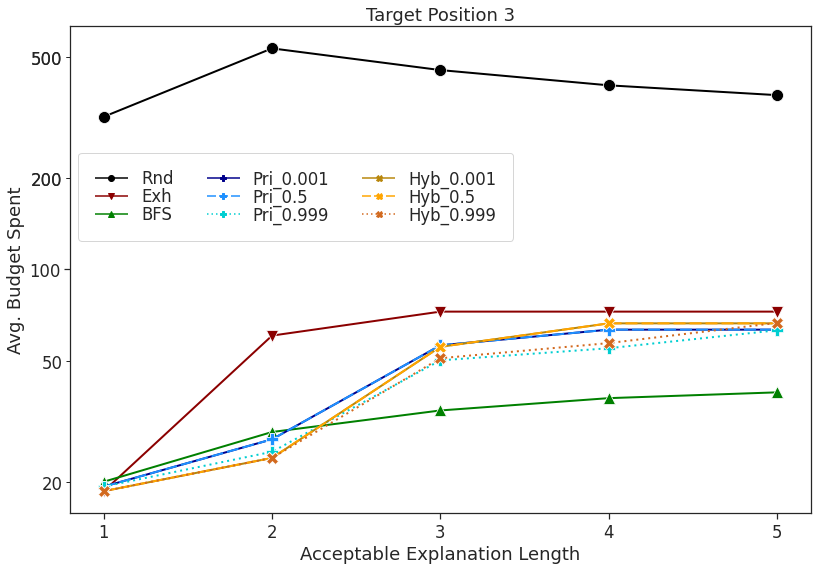

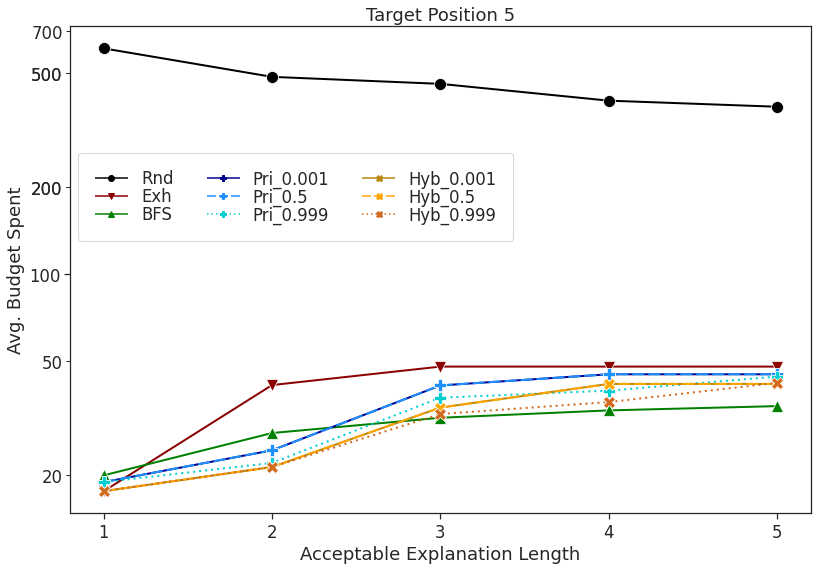

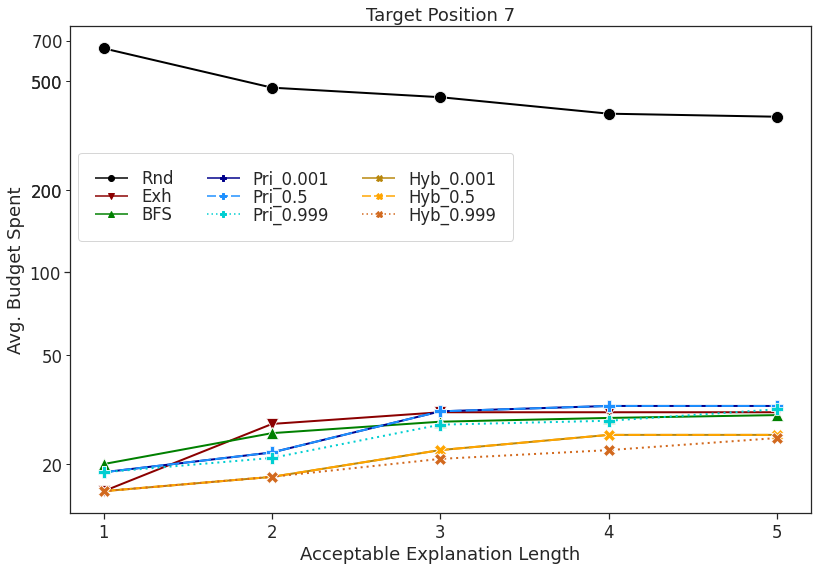

In [75]:
rows, cols = len(df.groupby('pos').groups.keys()), 1

for i, p in enumerate(df.groupby('pos').groups.keys()):
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize=a4_dims)

    g = sns.lineplot(
        ax=ax, data=ddf3[(ddf3['pos']==p)],
        x="cardinality", y="avg_budget", hue="method", style='method',
        palette=custom_palette, markers=custom_markers, markersize=12, dashes=custom_dashes, lw=2
    )
    g.set(yscale='log')
    locmin = mticker.LogLocator(base=10, subs=[10, 20, 50, 100, 200, 500, 700], numticks=12)
    ax.yaxis.set_minor_locator(locmin)
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))
    ax.yaxis.set_minor_formatter(mticker.FormatStrFormatter('%.0f'))
#     ax.yaxis.set_minor_formatter(mticker.NullFormatter())

    ax.set_xticks(np.arange(1, 6, 1))

#     plt.grid(True, which="both", ls="--", c='gray')

    lgnd = ax.legend(fancybox=True, frameon=True, labelspacing=0, borderpad=1, loc='center left', bbox_to_anchor=(0, 0.65), ncol=3,)
    # replace labels
    new_labels = ['Rnd', 'Exh', 'BFS', 'Pri_0.001', 'Pri_0.5', 'Pri_0.999', 'Hyb_0.001', 'Hyb_0.5', 'Hyb_0.999']
    for t, l in zip(lgnd.texts, new_labels): t.set_text(l)

    ax.set(xlabel="Acceptable Explanation Length", ylabel="Avg. Budget Spent")
    ax.set_title(f'Target Position {p}')

    fig.tight_layout()
    plt.savefig(os.path.join(plots_folder, f"avg_budget_to_card_pos_{p}.pdf"), dpi=300)

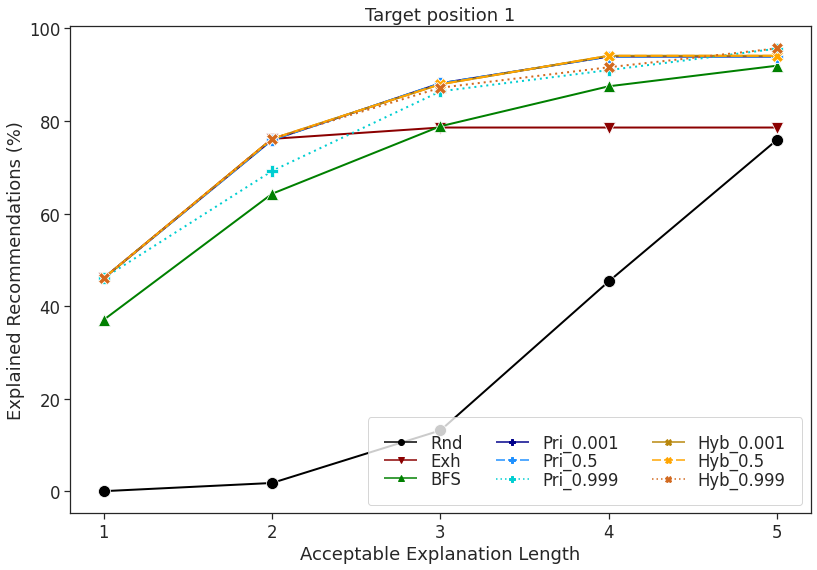

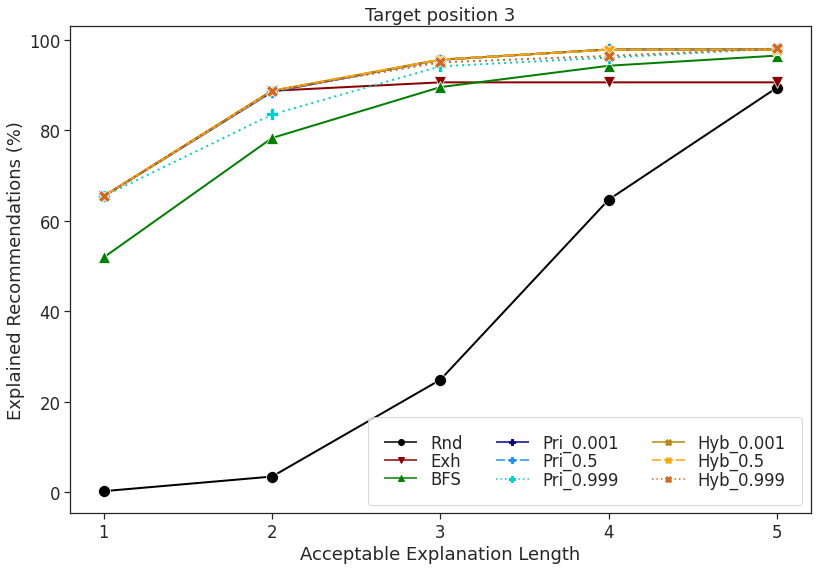

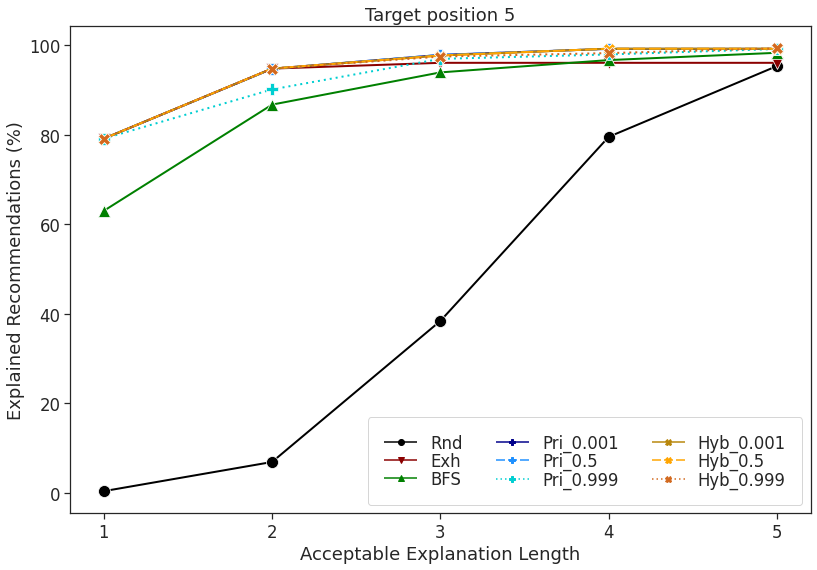

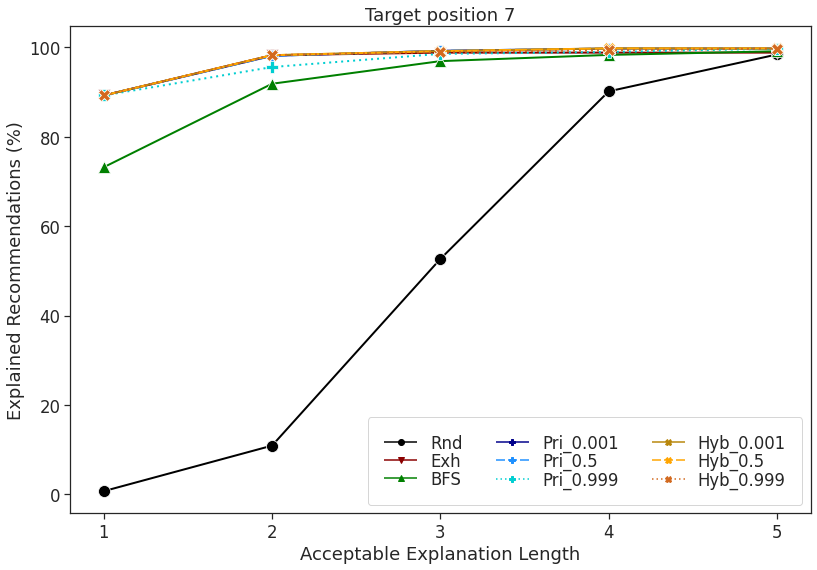

In [76]:
rows, cols = len(df.groupby('pos').groups.keys()), 1

for i, p in enumerate(df.groupby('pos').groups.keys()):
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize=a4_dims)

    g = sns.lineplot(ax=ax,
        data=ddf3[(ddf3['pos']==p) ],
        x="cardinality", y="%users", hue="method", style='method',
        palette=custom_palette, markers=custom_markers, markersize=12, dashes=custom_dashes, lw=2
    )

#     g.set(yscale='log')
#     locmin = mticker.LogLocator(base=10, subs=np.arange(0, 1, 0.1), numticks=12)
#     ax.yaxis.set_minor_locator(locmin)
#     ax.yaxis.set_minor_formatter(mticker.NullFormatter())
#     ax.yaxis.set_minor_formatter(mticker.NullFormatter())

    ax.set_xticks(np.arange(1, 6, 1))

#     plt.grid(True, which="both", ls="--", c='gray')

    lgnd = ax.legend(fancybox=True, frameon=True, labelspacing=0, borderpad=1, loc='lower right', ncol=3,)
    # replace labels
    new_labels = ['Rnd', 'Exh', 'BFS', 'Pri_0.001', 'Pri_0.5', 'Pri_0.999', 'Hyb_0.001', 'Hyb_0.5', 'Hyb_0.999']
    for t, l in zip(lgnd.texts, new_labels): t.set_text(l)

    ax.set(xlabel="Acceptable Explanation Length", ylabel="Explained Recommendations (%)")
    ax.set_title(f'Target position {p}')

    fig.tight_layout()
    plt.savefig(os.path.join(plots_folder, f"users_percent_to_card_pos_{p}.pdf"), dpi=300)

# Amazon

## Load data

In [55]:
## uncomment the following lines if you want to run the various strategies in budget_strategies
# implemented_strategies = os.path.join(base_dir, 'budget_strategies.ipynb')
# %run $implemented_strategies

%store -r amazon_random_cfs
%store -r amazon_brute_force_cfs

%store -r amazon_bfs_yloss_cfs
# %store -r dfs_yloss_cfs
# %store -r bestfs_yloss_cfs

%store -r amazon_bidirectional_cfs
%store -r amazon_combo_cfs

## Prepare data

In [57]:
from collections import Counter


# cnt = dict.fromkeys(most_sim_cfs.keys())
# no_target_achieved_cases = dict.fromkeys(most_sim_cfs.keys())
cnt = defaultdict(dict)
no_target_achieved_cases = defaultdict(list)
strs_prefix = 'amazon_'

for i in range(1):
    cnt, no_target_achieved_cases = convert_res_to_lists(
        getattr(current_module, f'{strs_prefix}{Strategies.stypes[0]}_cfs')[i],
        cnt, no_target_achieved_cases, f'random_{i}')
    cnt, no_target_achieved_cases = convert_res_to_lists(
        getattr(current_module, f'{strs_prefix}{Strategies.stypes[1]}_cfs')[i],
        cnt, no_target_achieved_cases, f'brute_force_{i}')

    cnt, no_target_achieved_cases = convert_res_to_lists(
        getattr(current_module, f'{strs_prefix}{Strategies.stypes[2]}_cfs')[i],
        cnt, no_target_achieved_cases, f'bfs_{i}')

    cnt, no_target_achieved_cases = convert_res_to_lists(
        getattr(current_module, f'{strs_prefix}{Strategies.stypes[3]}_cfs')[i],
        cnt, no_target_achieved_cases, f'bidirectional_001_{i}')
    cnt, no_target_achieved_cases = convert_res_to_lists(
        getattr(current_module, f'{strs_prefix}{Strategies.stypes[3]}_cfs')[i + 1],
        cnt, no_target_achieved_cases, f'bidirectional_5_{i}')
    cnt, no_target_achieved_cases = convert_res_to_lists(
        getattr(current_module, f'{strs_prefix}{Strategies.stypes[3]}_cfs')[i + 2],
        cnt, no_target_achieved_cases, f'bidirectional_999_{i}')

    cnt, no_target_achieved_cases = convert_res_to_lists(
        getattr(current_module, f'{strs_prefix}{Strategies.stypes[4]}_cfs')[i],
        cnt, no_target_achieved_cases, f'combo_001_{i}')
    cnt, no_target_achieved_cases = convert_res_to_lists(
        getattr(current_module, f'{strs_prefix}{Strategies.stypes[4]}_cfs')[i + 1],
        cnt, no_target_achieved_cases, f'combo_5_{i}')
    cnt, no_target_achieved_cases = convert_res_to_lists(
        getattr(current_module, f'{strs_prefix}{Strategies.stypes[4]}_cfs')[i + 2],
        cnt, no_target_achieved_cases, f'combo_999_{i}')

In [58]:
methods_supported = ['Brute_Force', 'Random', 'BFS'] + \
    [f'BiDirectional_{m}' for m in ['001', '5', '999']] + \
    [f'Combo_{m}' for m in ['001', '5', '999']]

strategies = [('init', 2), ('best', 3)]
custom_range = [9, 29]
target_pos = list(cnt.keys())
cnames = ['user_id', 'method', 'pos', 'budget', 'init_budget', 'best_budget', 'cardinality', 'cfs_orig', 'cfs']

rows, cols = 5, 1

tmp_dfs = []
for col in range(cols):
    for pos, row in zip(target_pos, range(rows)):

        tmp_dfs.append(pd.DataFrame.from_records(list(
            itertools.chain(*(
                zip(v[6], itertools.repeat(k), itertools.repeat(pos), v[i], v[2], v[3],
                    itertools.repeat(i - custom_range[0] + 1), v[7], v[8])
                for k, v in cnt[pos].items() if f'_{col}' in k and k.rsplit('_', 1)[0] in map(lambda x: x.lower(), methods_supported)
                for i in range(custom_range[0], custom_range[1])
            ))), columns=cnames
        ))

df = pd.concat(tmp_dfs, ignore_index=True)

In [59]:
idx = df.loc[(df['cfs_orig'] == df['cfs'])].duplicated(subset=['user_id', 'method', 'pos'], keep='last')
df.loc[(df['cfs_orig'] == df['cfs']) & ~idx, ['budget']] = df.loc[(df['cfs_orig'] == df['cfs']) & ~idx]['best_budget']

In [60]:
def grouping(x, i=1):
    users_uniq = x['user_id'].nunique()
    print(x.columns)
    mask = x.apply(lambda d : d['cardinality'] <= i)
    no_users = x.loc[mask].sum()
#     journal_author = x.groupby('Journal').apply(lambda d : ((((d['Subscription'] == 1) & (d['Known_author'] == 1)).sum()) > 0)).sum()
    return pd.Series([no_users])
# ddf = df.groupby(['method', 'pos']).apply(grouping)


# # 1st plot: %users per card
all_users = df['user_id'].nunique()

res = []
for i in range(1, 21):
    res.append(df[(df['budget'] > 0) & (df['cardinality'] <= i) & (df['best_budget'] <= 1000)]
               .groupby(['method', 'pos'], sort=False)[['user_id', 'cfs']]
               .nunique()
               .reset_index())

ddf = pd.concat(res, ignore_index=True)
ddf['%users'] = (ddf['user_id'] / all_users) * 100

# 2nd plot: average budget
max_card = 5
init = 100
end = 1001
step = 100


res = []
for b in range(init, end, step):
    aggregated = df[(df['budget'] > 0) & (df['best_budget'] <= b)]\
        .groupby(['method', 'pos'], sort=False)\
        .agg(card_mean=('cfs', 'mean'), no_users=('user_id', 'nunique'))\
        .reset_index()
    aggregated['budget_thres'] = b
    aggregated['max_users'] = aggregated.groupby(['pos'])['no_users'].transform(max)
    res.append(aggregated)

ddf2 = pd.concat(res, ignore_index=True)
ddf2['%users'] = (ddf2['no_users'] / all_users) * 100
# ddf2['combined_means'] = ((ddf2['card_mean'] * ddf2['no_users']) + (20 * (ddf2['max_users'] - ddf2['no_users']))) / (ddf2['max_users'])
ddf2['combined_means'] = ddf2['card_mean']


# 3rd plot:
def aggf(data):
    users_grouping = data.groupby(['user_id']).apply(
        lambda d: d.loc[d['budget'] == d['budget'].max()]
    )

    return pd.Series(
        [users_grouping['budget'].mean(),
         users_grouping['user_id'].count()],
        ['avg_budget', 'no_users']
    )

# .apply(lambda d: pd.Series(dict(
#             avg_budget=d.groupby(['user_id']).apply(
#                 lambda x: x.loc[(x['cardinality'] == x['cardinality'].min()), 'budget'].mean(),
#             ),
# #             no_users=d.loc[d['cardinality'],min(), 'user_id'].count(),
#             max_users=d['user_id'].nunique()
#         )))\


res = []
for i in range(5, 0, -1):
    aggregated = df[(df['budget'] > 0) & (df['cardinality'] <= i) & (df['best_budget'] <= 1000)]\
        .groupby(['method', 'pos'], sort=False)\
        .apply(aggf)\
        .reset_index()
    aggregated['cardinality'] = i
    res.append(aggregated)

ddf3 = pd.concat(res, ignore_index=True)
ddf3['%users'] = (ddf3['no_users'] / all_users) * 100

## Plots

In [61]:
import matplotlib.ticker as mticker


sns.set_theme(style="ticks", font_scale=1.5, )

# Create an array with the colors you want to use
# colors = ["#FF0B04", "#4374B3", "#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
colors = ['black', 'darkred', 'green', 'darkblue', 'dodgerblue', 'darkturquoise', 'darkgoldenrod', 'orange', 'chocolate']

# Set your custom color palette
custom_palette = sns.set_palette(sns.color_palette(colors))

# custom_markers = ['o', 'v', '^', 's', 'P', 'X', '<', '>', 'D', ]
custom_markers = ['o', 'v', '^', 'P', 'P', 'P', 'X', 'X', 'X']
custom_dashes = [(1, 0), (4, 0), (4, 0), (4, 0), (6, 2), (1, 2), (1, 0), (6, 2), (1, 2)]

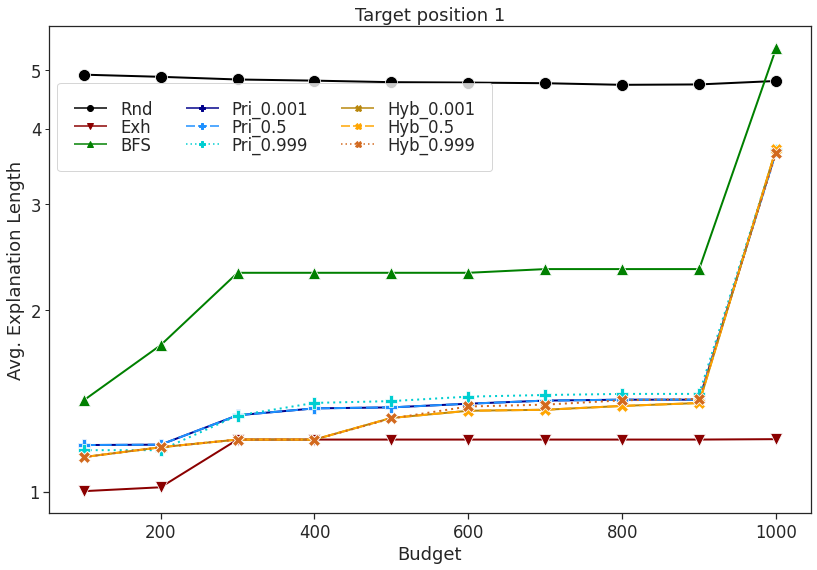

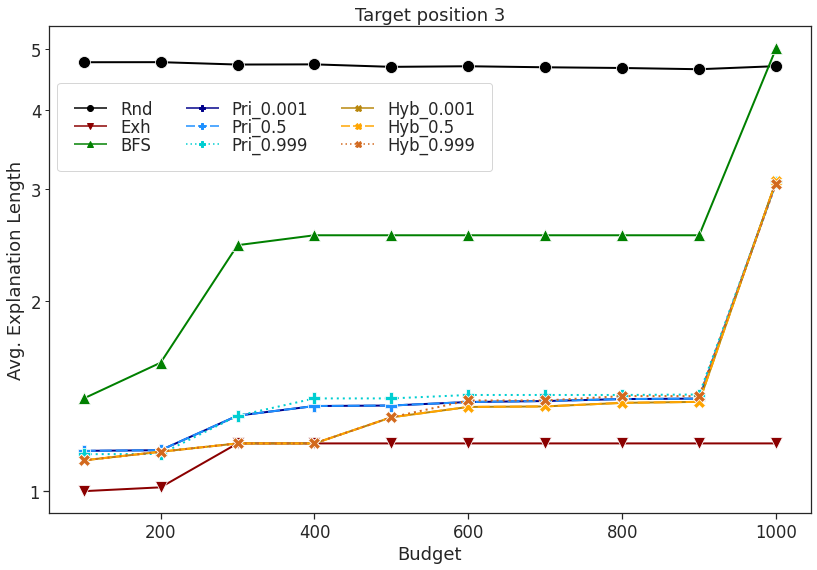

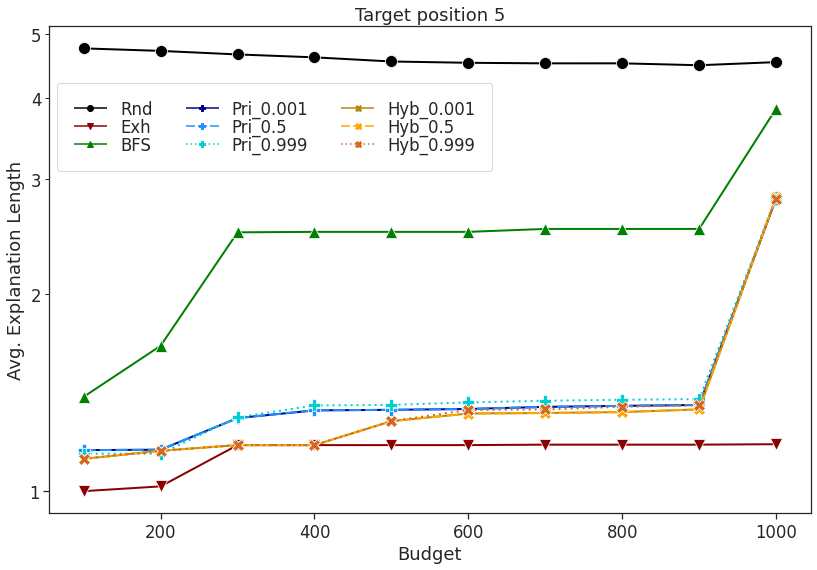

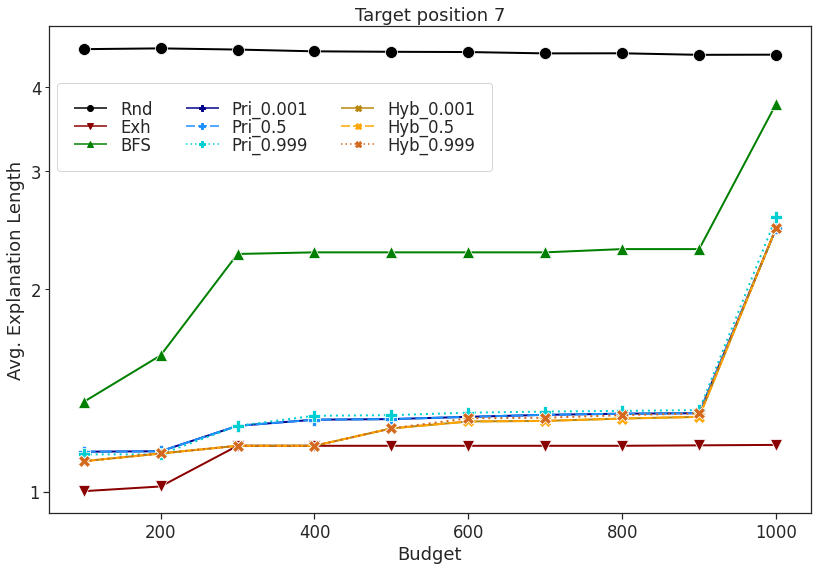

In [62]:
# Draw a nested barplot by species and sex
# g = sns.catplot(
#     data=ddf2[ddf2['pos']==3], kind="bar",
#     x="budget_thres", y='combined_means', hue="method",
#     ci=None, palette="dark", alpha=.8, height=6, aspect=4,
# )

# num_locations = len(ddf2.groupby('budget_thres').groups.keys())
# hatches = itertools.cycle(['//', '+', '-', 'x', '\\', '*', 'o', '.'])
# for i, bar in enumerate(g.ax.patches):
#     if i % num_locations == 0:
#         hatch = next(hatches)
#     bar.set_hatch(hatch)

# g.ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=3, fancybox=True, shadow=False)

# g.despine(left=True)
# g.set_axis_labels("threshold", "cardinality average")
# g.legend.set_title("")

rows, cols = len(df.groupby('pos').groups.keys()), 1

for i, p in enumerate(df.groupby('pos').groups.keys()):
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize=a4_dims)

    g = sns.lineplot(
        ax=ax, data=ddf2[(ddf2['pos'] == p)],
        x="budget_thres", y="card_mean", hue="method", style='method',
        palette=custom_palette,
        markers=custom_markers, markersize=12, lw=2, ls='solid', dashes=custom_dashes
    )

    g.set(yscale='log')
#     locmin = mticker.LogLocator(base=10, subs=np.arange(0, 1, 0.1), numticks=12)
#     ax.yaxis.set_minor_locator(locmin)
#     ax.yaxis.set_minor_formatter(mticker.NullFormatter())
#     ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
#     ax.yaxis.get_major_formatter().set_scientific(False)
#     ax.yaxis.get_major_formatter().set_useOffset(False)

    # Turns on grid on the Axis.
#     plt.grid(True, which="both", ls="--", c='gray')
#     scientific_formatter = mticker.FuncFormatter()
#     ax.yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))
    ax.yaxis.set_minor_formatter(mticker.FormatStrFormatter('%.0f'))

    lgnd = ax.legend(fancybox=True, frameon=True, labelspacing=0, borderpad=1, loc='upper left', bbox_to_anchor=(0, 0.9), ncol=3,)

    # replace labels
    new_labels = ['Rnd', 'Exh', 'BFS', 'Pri_0.001', 'Pri_0.5', 'Pri_0.999', 'Hyb_0.001', 'Hyb_0.5', 'Hyb_0.999']
    for t, l in zip(lgnd.texts, new_labels): t.set_text(l)

    ax.set(xlabel="Budget", ylabel="Avg. Explanation Length")
    ax.set_title(f'Target position {p}')

    fig.tight_layout()
    plt.savefig(os.path.join(plots_folder, f"{strs_prefix}avg_card_to_thres_pos_{p}.pdf"), dpi=300)

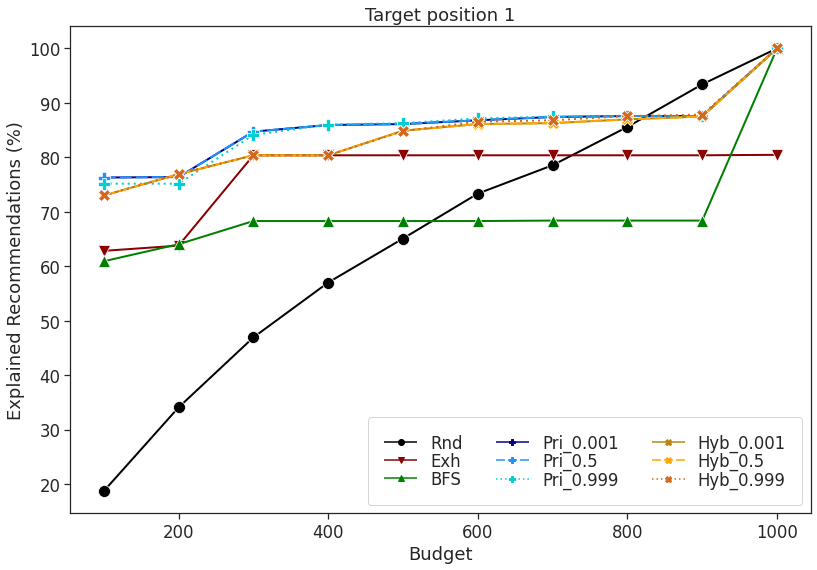

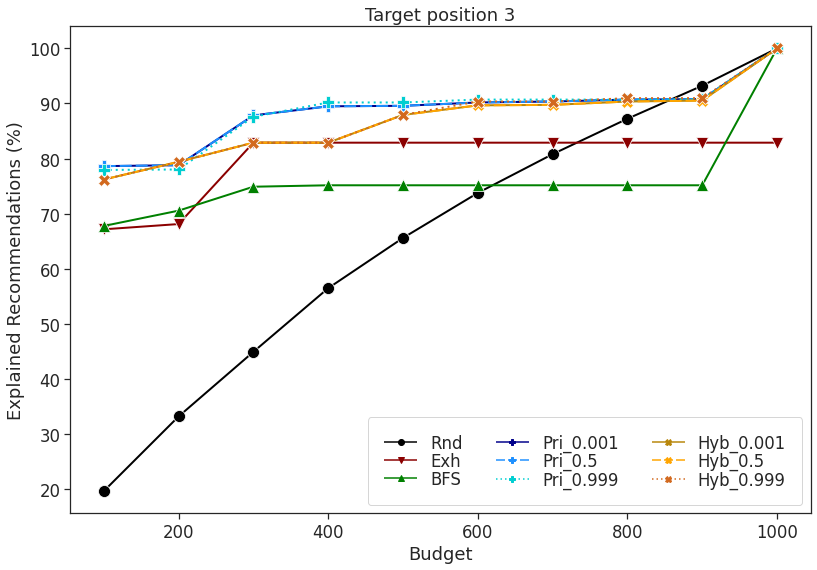

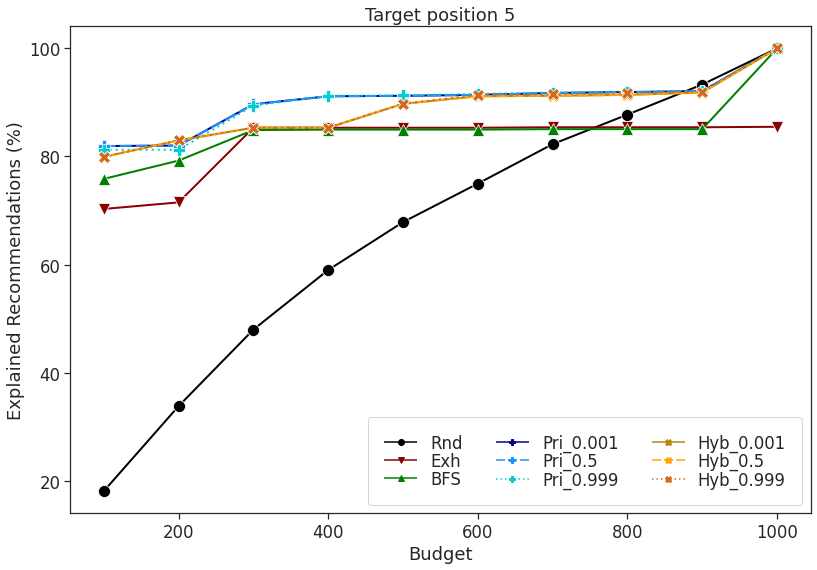

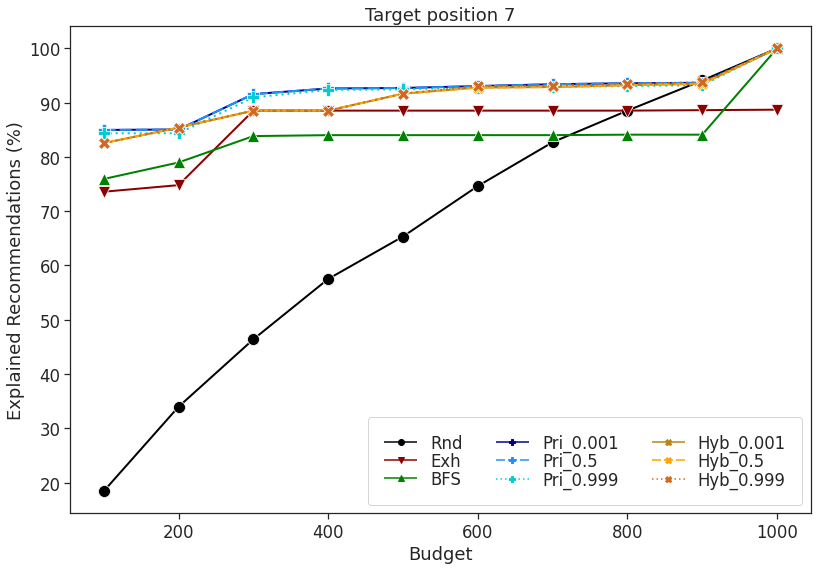

In [66]:
rows, cols = len(df.groupby('pos').groups.keys()), 1

for i, p in enumerate(df.groupby('pos').groups.keys()):
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize=a4_dims)

    g = sns.lineplot(
        ax=ax, data=ddf2[(ddf2['pos'] == p)],
        x="budget_thres", y="%users", hue="method", style='method',
        palette=custom_palette, markers=custom_markers, markersize=12, dashes=custom_dashes, lw=2,
    )

#     g.set(yscale='log')
#     locmin = mticker.LogLocator(base=10, subs=np.arange(0, 1, 0.1), numticks=12)
#     ax.yaxis.set_minor_locator(locmin)
#     ax.yaxis.set_minor_formatter(mticker.NullFormatter())

#     plt.grid(True, which="both", ls="--", c='gray')

    lgnd = ax.legend(fancybox=True, frameon=True, labelspacing=0, borderpad=1, loc='lower right', ncol=3,)

    # replace labels
    new_labels = ['Rnd', 'Exh', 'BFS', 'Pri_0.001', 'Pri_0.5', 'Pri_0.999', 'Hyb_0.001', 'Hyb_0.5', 'Hyb_0.999']
    for t, l in zip(lgnd.texts, new_labels): t.set_text(l)

    ax.set(xlabel="Budget", ylabel="Explained Recommendations (%)")
    ax.set_title(f'Target position {p}')

    fig.tight_layout()
    plt.savefig(os.path.join(plots_folder, f"{strs_prefix}users_percent_to_thres_pos_{p}.pdf"), dpi=300)

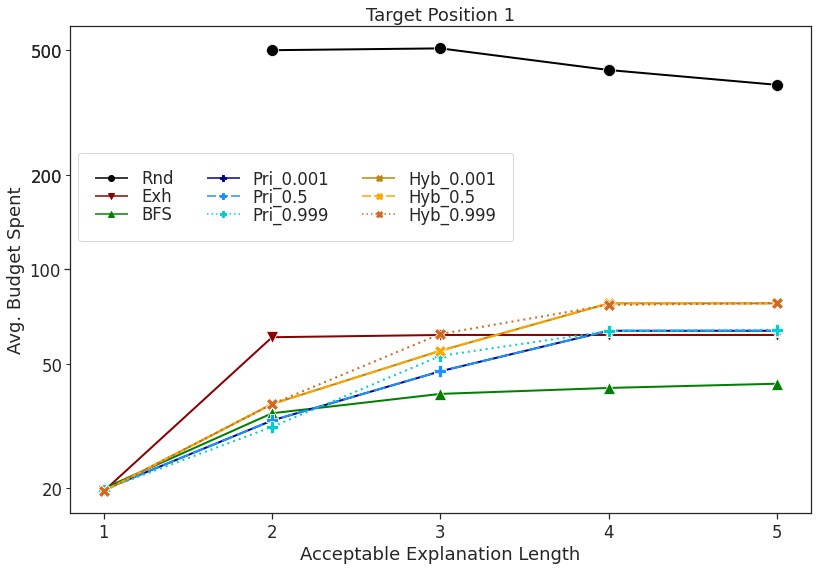

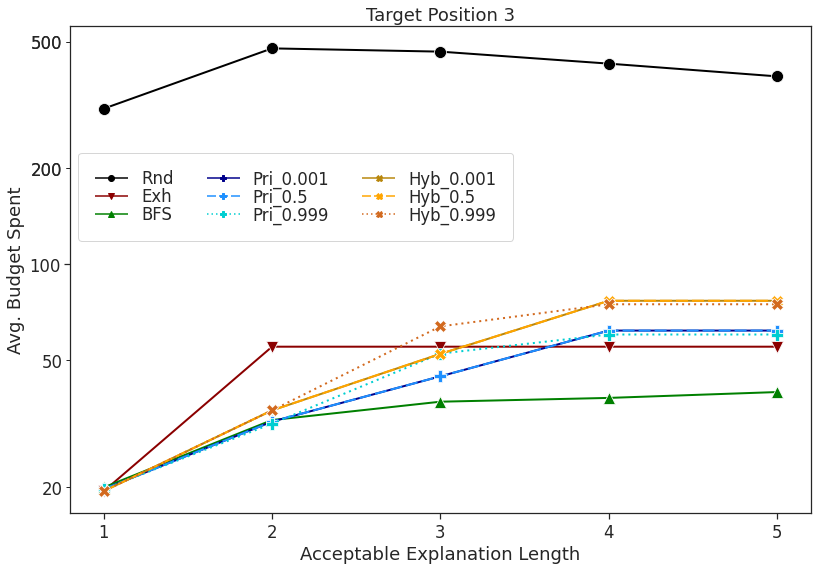

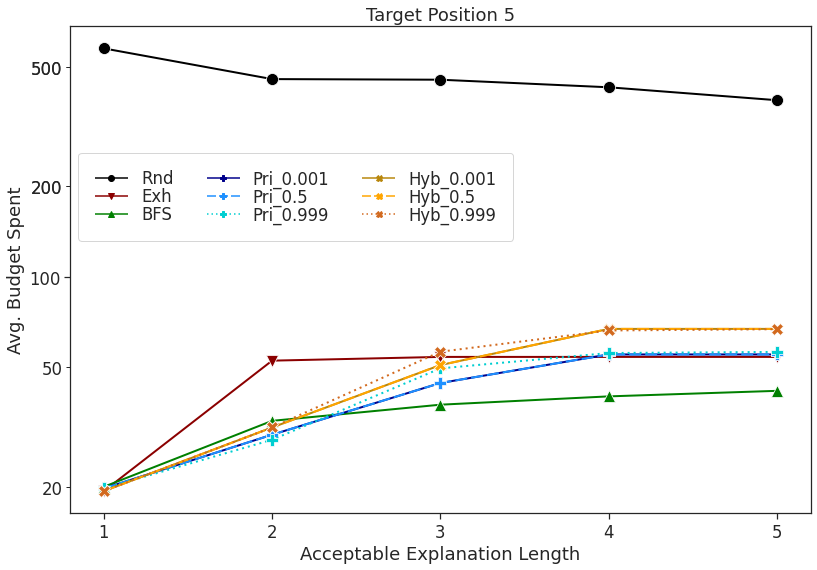

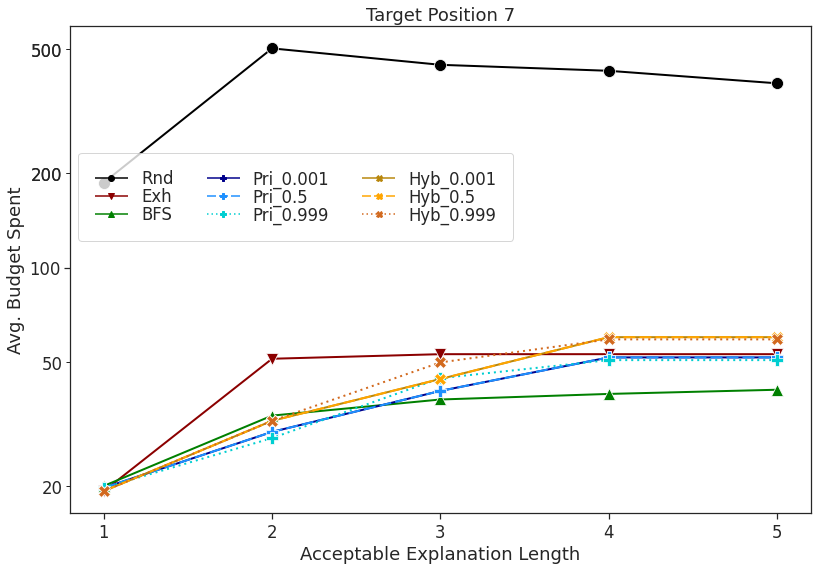

In [64]:
rows, cols = len(df.groupby('pos').groups.keys()), 1

for i, p in enumerate(df.groupby('pos').groups.keys()):
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize=a4_dims)

    g = sns.lineplot(
        ax=ax, data=ddf3[(ddf3['pos']==p)],
        x="cardinality", y="avg_budget", hue="method", style='method',
        palette=custom_palette, markers=custom_markers, markersize=12, dashes=custom_dashes, lw=2
    )
    g.set(yscale='log')
    locmin = mticker.LogLocator(base=10, subs=[10, 20, 50, 100, 200, 500, 700], numticks=12)
    ax.yaxis.set_minor_locator(locmin)
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))
    ax.yaxis.set_minor_formatter(mticker.FormatStrFormatter('%.0f'))
#     ax.yaxis.set_minor_formatter(mticker.NullFormatter())

    ax.set_xticks(np.arange(1, 6, 1))

#     plt.grid(True, which="both", ls="--", c='gray')

    lgnd = ax.legend(fancybox=True, frameon=True, labelspacing=0, borderpad=1, loc='center left', bbox_to_anchor=(0, 0.65), ncol=3,)
    # replace labels
    new_labels = ['Rnd', 'Exh', 'BFS', 'Pri_0.001', 'Pri_0.5', 'Pri_0.999', 'Hyb_0.001', 'Hyb_0.5', 'Hyb_0.999']
    for t, l in zip(lgnd.texts, new_labels): t.set_text(l)

    ax.set(xlabel="Acceptable Explanation Length", ylabel="Avg. Budget Spent")
    ax.set_title(f'Target Position {p}')

    fig.tight_layout()
    plt.savefig(os.path.join(plots_folder, f"{strs_prefix}avg_budget_to_card_pos_{p}.pdf"), dpi=300)

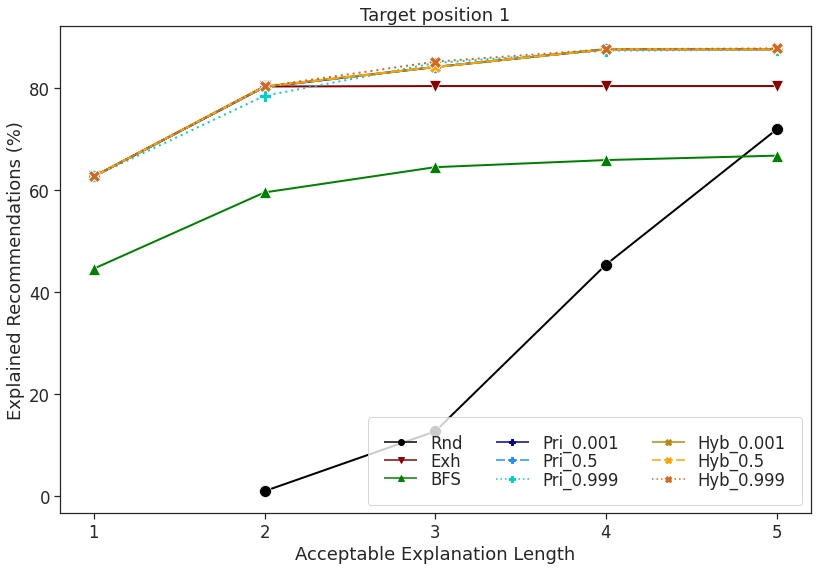

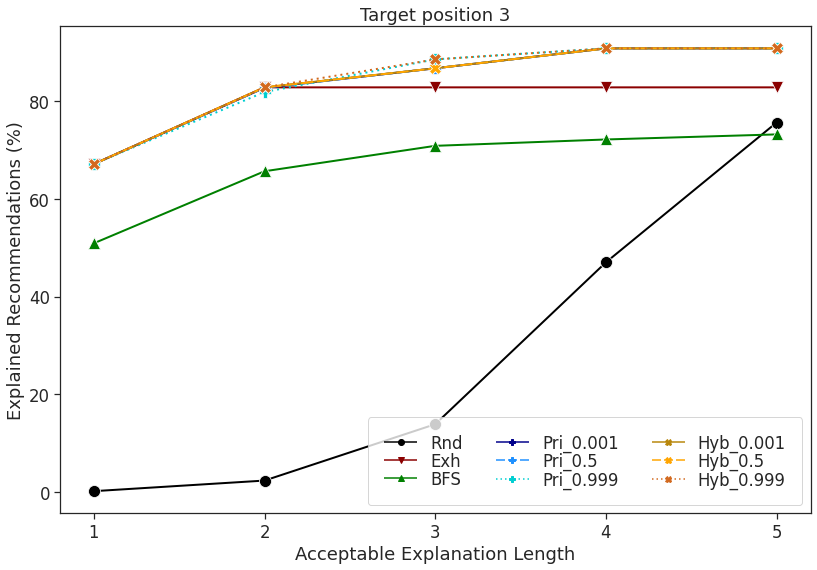

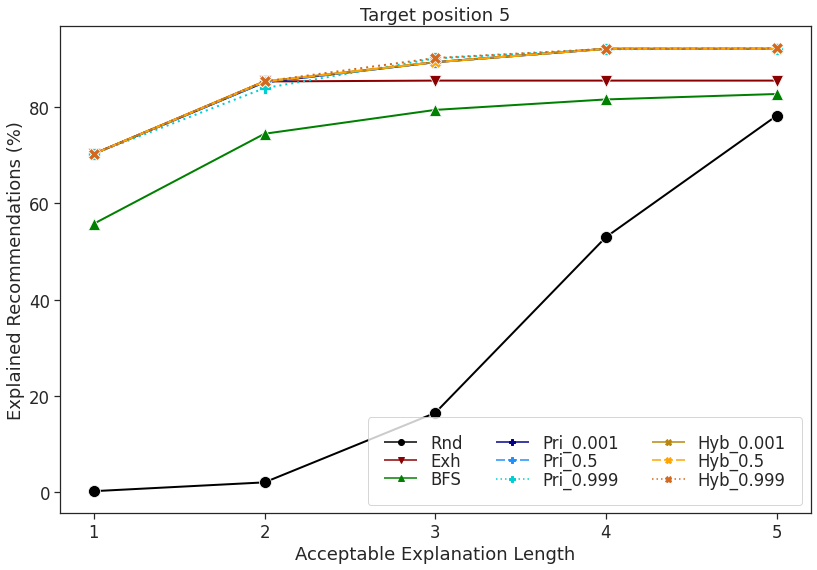

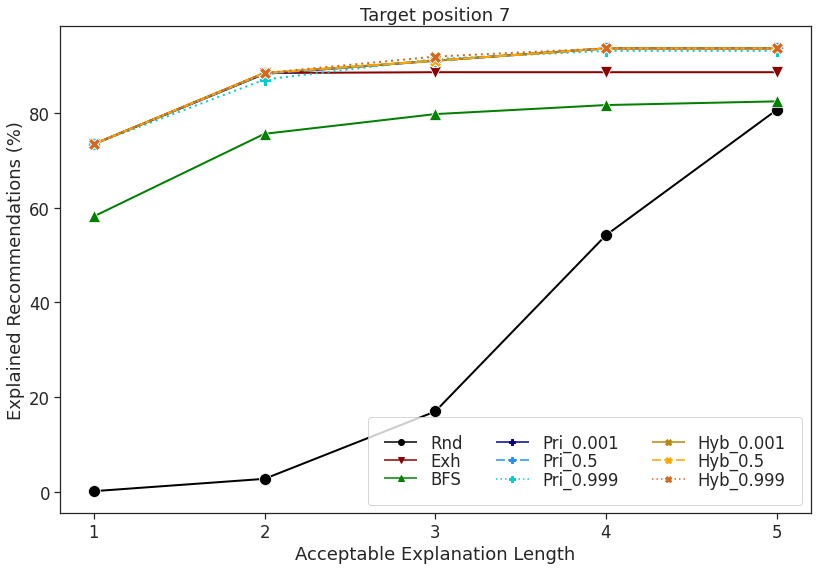

In [65]:
rows, cols = len(df.groupby('pos').groups.keys()), 1

for i, p in enumerate(df.groupby('pos').groups.keys()):
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize=a4_dims)

    g = sns.lineplot(ax=ax,
        data=ddf3[(ddf3['pos']==p) ],
        x="cardinality", y="%users", hue="method", style='method',
        palette=custom_palette, markers=custom_markers, markersize=12, dashes=custom_dashes, lw=2
    )

#     g.set(yscale='log')
#     locmin = mticker.LogLocator(base=10, subs=np.arange(0, 1, 0.1), numticks=12)
#     ax.yaxis.set_minor_locator(locmin)
#     ax.yaxis.set_minor_formatter(mticker.NullFormatter())
#     ax.yaxis.set_minor_formatter(mticker.NullFormatter())

    ax.set_xticks(np.arange(1, 6, 1))

#     plt.grid(True, which="both", ls="--", c='gray')

    lgnd = ax.legend(fancybox=True, frameon=True, labelspacing=0, borderpad=1, loc='lower right', ncol=3,)
    # replace labels
    new_labels = ['Rnd', 'Exh', 'BFS', 'Pri_0.001', 'Pri_0.5', 'Pri_0.999', 'Hyb_0.001', 'Hyb_0.5', 'Hyb_0.999']
    for t, l in zip(lgnd.texts, new_labels): t.set_text(l)

    ax.set(xlabel="Acceptable Explanation Length", ylabel="Explained Recommendations (%)")
    ax.set_title(f'Target position {p}')

    fig.tight_layout()
    plt.savefig(os.path.join(plots_folder, f"{strs_prefix}users_percent_to_card_pos_{p}.pdf"), dpi=300)